<a href="https://colab.research.google.com/github/asangphukieo/CMUTEAM_NF_pipeline/blob/main/Copy_of_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xray Classification

We will train deep neural network model to classify x-ray images.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Get data and extract data

In [ ]:
!wget -O xray_data.zip "https://www.dropbox.com/s/wr8iky2gdbqeyyt/data.zip?dl=0"

--2022-01-22 04:54:28--  https://www.dropbox.com/s/wr8iky2gdbqeyyt/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/wr8iky2gdbqeyyt/data.zip [following]
--2022-01-22 04:54:28--  https://www.dropbox.com/s/raw/wr8iky2gdbqeyyt/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbefdbaffd6bfb3884a26dadc28.dl.dropboxusercontent.com/cd/0/inline/BeN24JV_uQb4JCyFrtqrQHpBJGXaBVFWrfsERhcLpxN71a1xWsSQr_t37Gd-DHY9EZbq7IQs-jThlUrB56aByCYPIXcFO60xzJ6MI9XUWADMeUclLgBZY1VSw9U7ATvJGi8AJRj6bluUAPhprryQe_eP/file# [following]
--2022-01-22 04:54:29--  https://ucbefdbaffd6bfb3884a26dadc28.dl.dropboxusercontent.com/cd/0/inline/BeN24JV_uQb4JCyFrtqrQHpBJGXaBVFWrfsERhcLpxN71a1xWsSQr_t37Gd-DHY9EZbq7IQs-jThlUrB56aByCYPIXcFO60xz

In [ ]:
!unzip "xray_data.zip"

# Load data and view sample data

In [ ]:
import pandas as pd

print(pd.__version__)
# 0.22.0

import fastai as fs
print(fs.__version__)

1.1.5
1.0.61


In [ ]:
from fastai.vision import ImageList

ValueError: ignored

In [ ]:
#conda activate fastai
#conda install -c fastai 
#conda install -c pytorch pytorch
#conda install -c conda-forge pytorch-model-summary
#conda install -c anaconda scikit-learn
from fastai.vision import ImageList
data = (ImageList.from_folder('./data')
        .split_by_folder()
        .label_from_folder()
        .transform(size=32)
        .databunch(num_workers=4))

ValueError: ignored

In [ ]:
from fastai.vision.all import *
fields = DataBlock(blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   get_y=parent_label,
   splitter=RandomSplitter(valid_pct=0.2, seed=42),
   item_tfms=RandomResizedCrop(224, min_scale=0.5),
   batch_tfms=aug_transforms())

In [ ]:
data.show_batch()

# Construct deep neural network model and view model summary

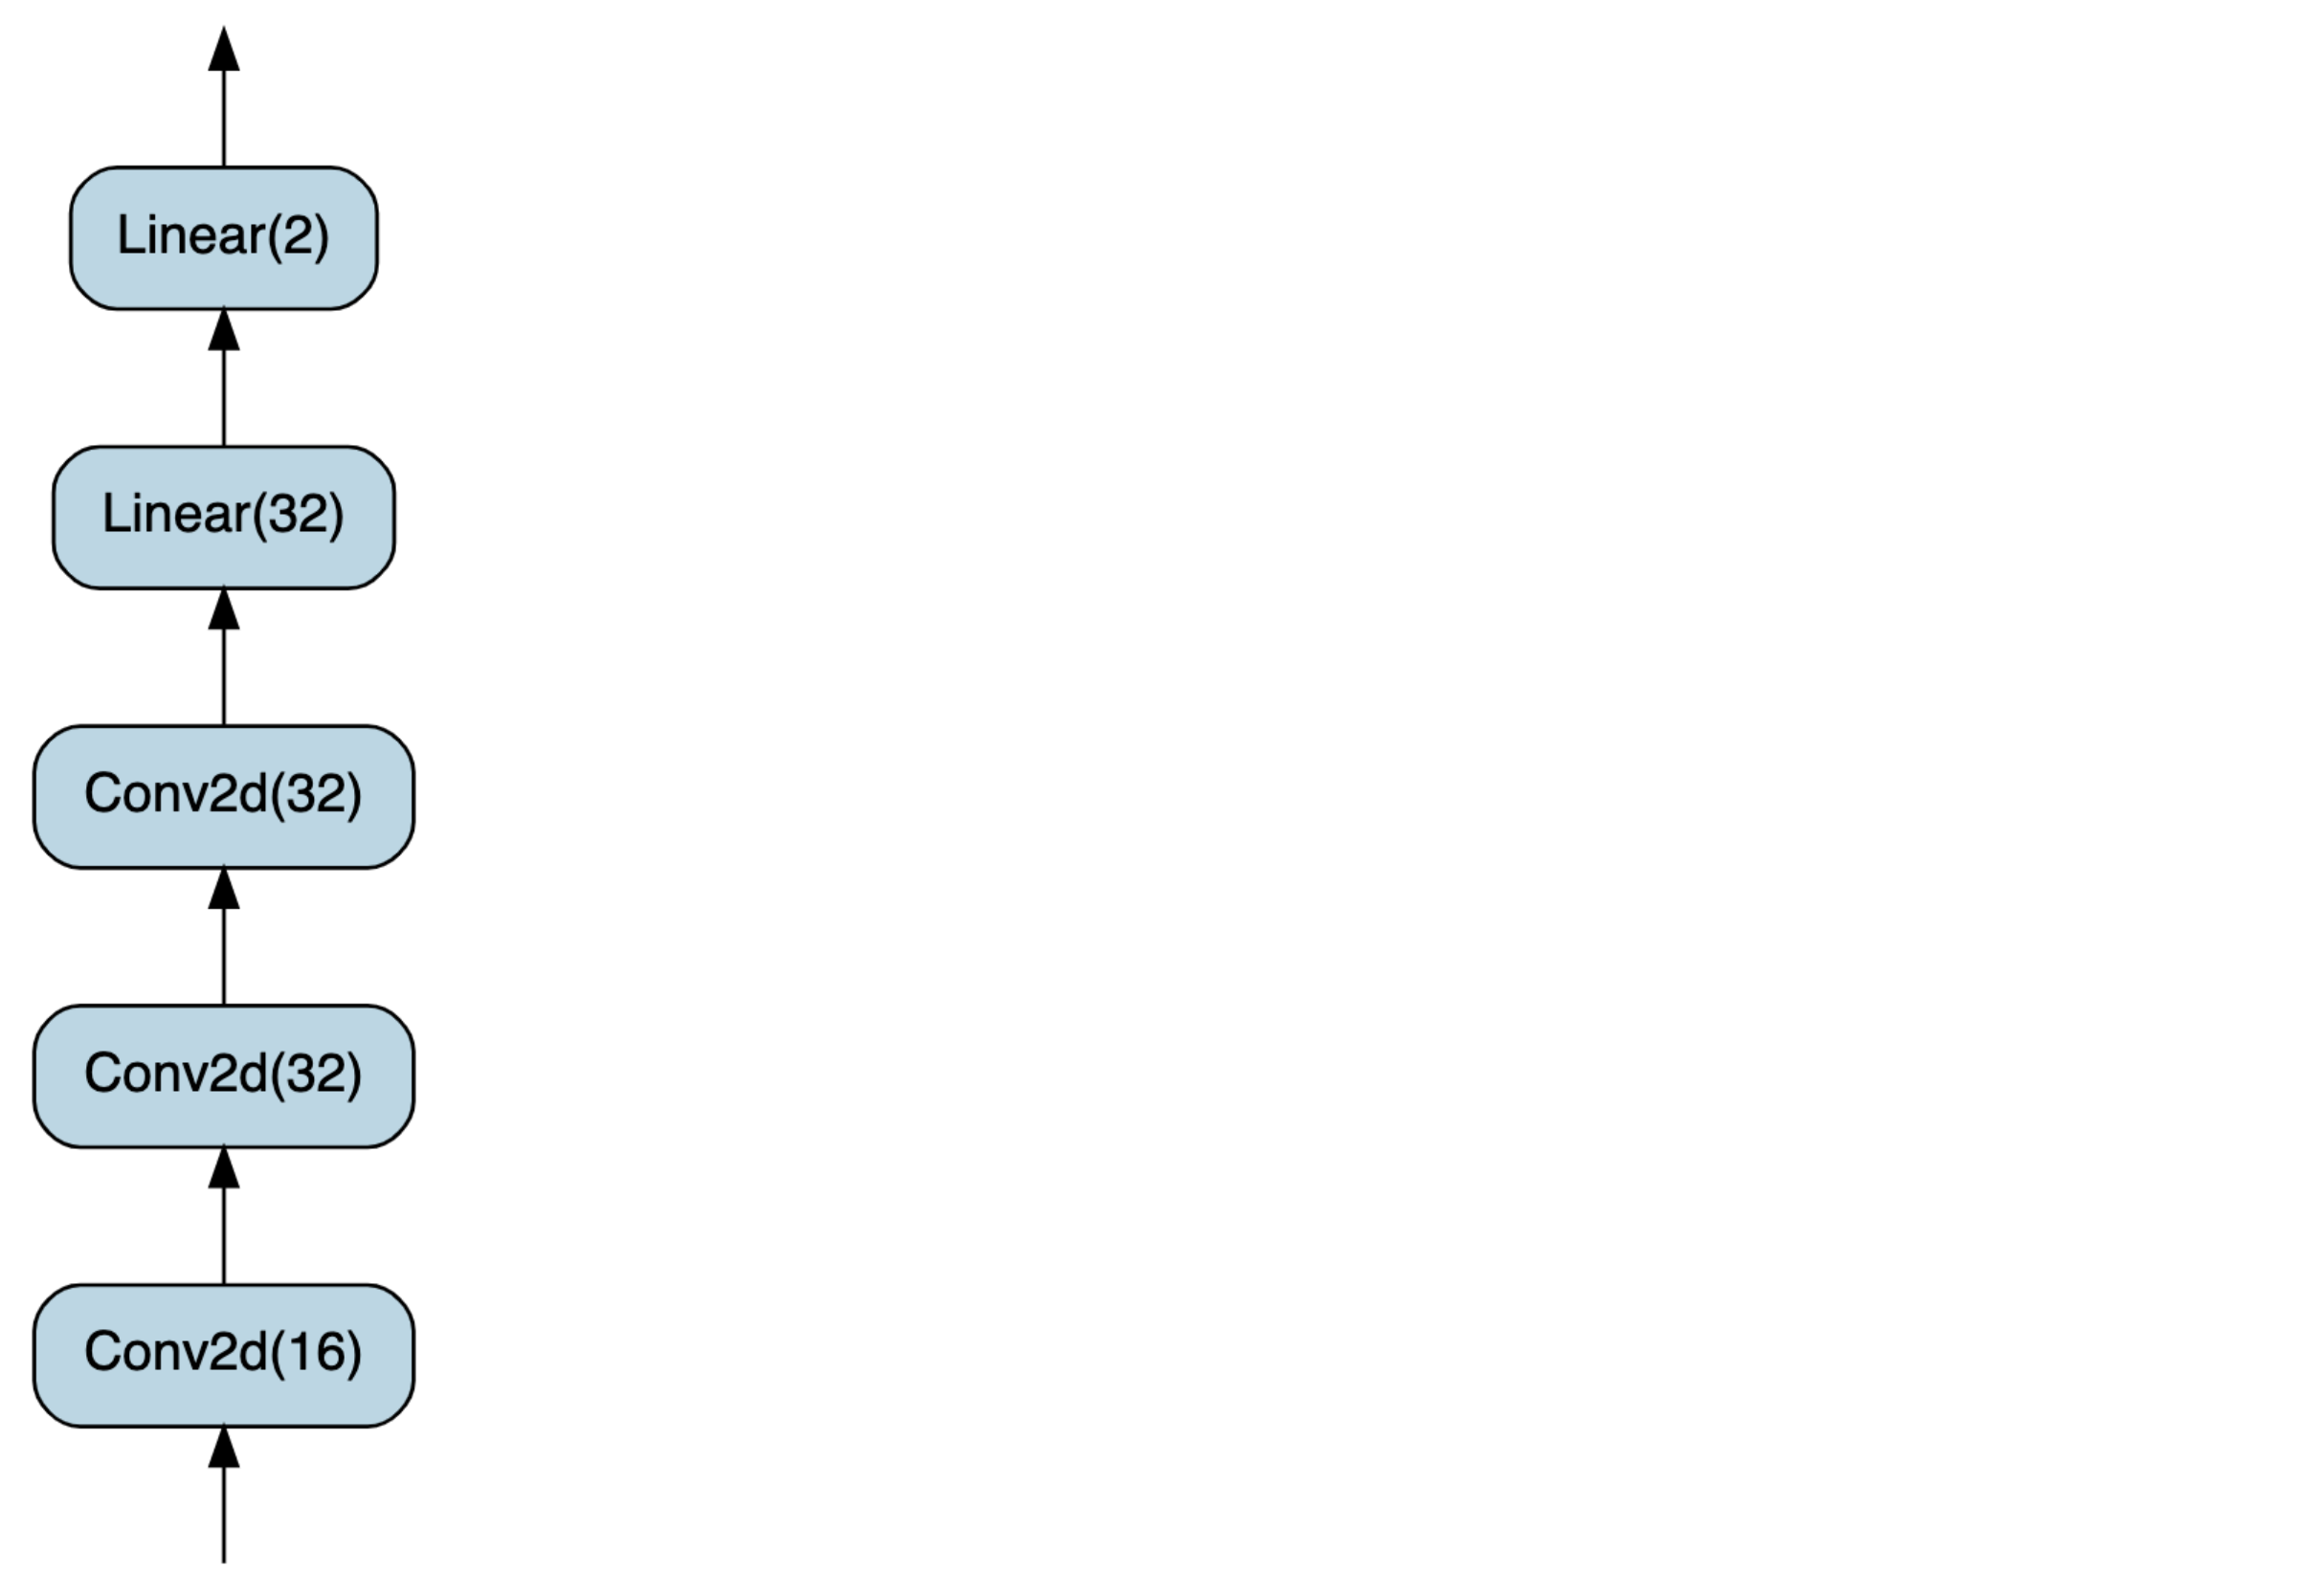

In [ ]:
import torch.nn as nn

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # linear stack of layers
    self.main = nn.Sequential(
        # input is going into a convolution
        nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # 2d convolution layer
        nn.ReLU(), # relu activation
        nn.MaxPool2d(kernel_size=3, stride=2), # 2d max pooling

        nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # 2d convolution layer
        nn.ReLU(), # relu activation
        nn.MaxPool2d(kernel_size=3, stride=2), # 2d max pooling

        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # 2d convolution layer
        nn.ReLU(), # relu activation
        nn.MaxPool2d(kernel_size=3, stride=2), # 2d max pooling

        nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # 2d convolution layer
        nn.ReLU(), # relu activation
        nn.MaxPool2d(kernel_size=3, stride=2), # 2d max pooling

        nn.AdaptiveAvgPool2d(output_size=(1, 1)), # adaptive 2d average pooling
        nn.Flatten(),
        nn.Dropout(0.3), # dropout for regularization
        nn.Linear(32, 16), # fully connected layer
        nn.ReLU(), # relu activation
        nn.Dropout(0.3), # dropout for regularization
        nn.Linear(16, 2), # final classification layer
    )
  def forward(self, x):
    y = self.main(x)
    return y
  

In [ ]:
# learn.show_results()
from torchsummary import summary
net = Net()
net.cuda() #turn on if get "RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same"
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 15, 15]               0
            Conv2d-4           [-1, 64, 15, 15]           9,280
              ReLU-5           [-1, 64, 15, 15]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          36,928
              ReLU-8             [-1, 64, 7, 7]               0
         MaxPool2d-9             [-1, 64, 3, 3]               0
           Conv2d-10             [-1, 32, 3, 3]          18,464
             ReLU-11             [-1, 32, 3, 3]               0
        MaxPool2d-12             [-1, 32, 1, 1]               0
AdaptiveAvgPool2d-13             [-1, 32, 1, 1]               0
          Flatten-14                   

# Train the model and inspect results

In [ ]:
from fastai.vision import Learner, accuracy
import torch
learn = Learner(data, net, loss_func=torch.nn.CrossEntropyLoss(), metrics=[accuracy])

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_b

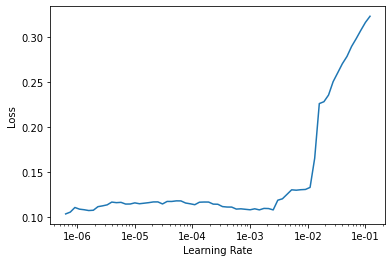

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.106280,0.692443,0.786859,00:41
1,0.127204,0.320494,0.886218,00:41
2,0.092783,0.428800,0.870192,00:42
3,0.091711,0.333728,0.878205,00:41
4,0.081936,0.560052,0.833333,00:43
5,0.076051,0.370993,0.884615,00:43
6,0.073596,0.366143,0.876603,00:43
7,0.072220,0.315183,0.897436,00:44
8,0.067465,0.747000,0.810897,00:44
9,0.063698,0.501635,0.850962,00:44


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

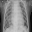

In [ ]:
learn.data.train_ds[0] #Return predicted class, label and probabilities for item.
test = learn.data.train_ds[0][0] # get 1 data to test
test

In [ ]:
pred = learn.predict(test) # predicted class and label, pro of each class
pred

(Category tensor(1), tensor(1), tensor([0.0111, 0.9889]))

In [ ]:
learn.data.classes

['NORMAL', 'PNEUMONIA']

In [ ]:
pred[2] #prob of predicted and target


tensor([0.0111, 0.9889])

In [ ]:
print(learn.data.classes[1],pred[2][1])


PNEUMONIA tensor(0.9889)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


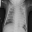

In [ ]:
learn.data.valid_ds[0][0]

In [ ]:
preds = learn.get_preds() #predictios from whole dataset

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packa

In [ ]:
preds[0] #tuple is a tensor that contains all the predictions

tensor([[1.8359e-03, 9.9816e-01],
        [3.6923e-02, 9.6308e-01],
        [4.3076e-04, 9.9957e-01],
        ...,
        [1.2361e-03, 9.9876e-01],
        [1.2152e-01, 8.7848e-01],
        [2.5080e-01, 7.4920e-01]])

In [ ]:
preds[1] #tuple is a tensor that contains all the target labels.

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
len(learn.data.valid_ds) #gets predictions on all the data in the ds_type dataset, here the number of predictions will be equal to the number of data in the validation dataset.

624

In [ ]:
len(learn.data.train_ds)

5232

In [ ]:
len(preds[0]), len(preds[1]) 

(624, 624)

In [ ]:
learn.get_preds() # To get predictions on the entire training dataset,

IndexError: ignored

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

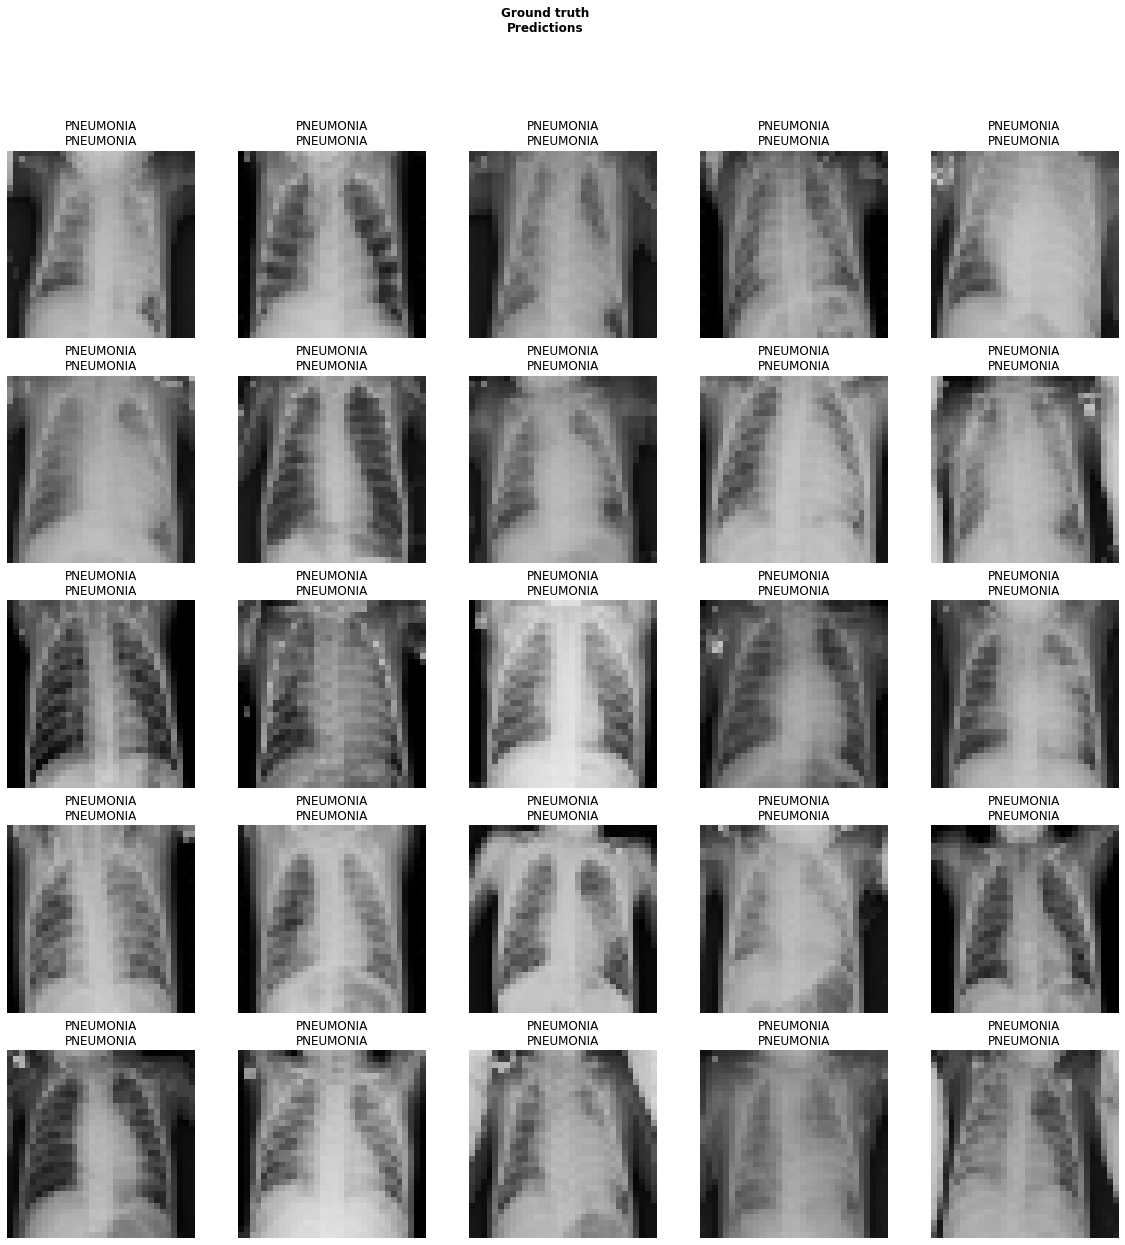

In [ ]:
learn.show_results()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packa

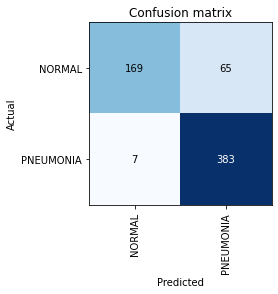

In [ ]:
from fastai.vision import learner
interp = learner.ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix() #gui

In [ ]:
interp.confusion_matrix(slice_size=10) #ot gui

array([[169,  65],
       [  7, 383]])

In [ ]:
#export model to pkl
learn.export('trained_model.pkl')

In [ ]:
import torch
x = torch.randn(1, 3, 32, 32, requires_grad=True).cuda()
# torch_out = model(x)

learn.model.eval()
# Export the model
torch.onnx.export(learn.model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "xray_model.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=7,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

In [ ]:
x

tensor([[[[ 0.0581,  0.3215, -0.1649,  ...,  0.9671, -0.7810, -0.0264],
          [ 0.1145, -0.1359,  1.5354,  ..., -1.6903, -1.0140, -0.9770],
          [ 2.6253,  0.0626,  1.0989,  ...,  1.5981, -1.2075,  0.0205],
          ...,
          [-1.1713,  0.0135, -0.6048,  ...,  0.8356,  0.1734, -0.6976],
          [-0.1868, -0.7854, -1.3237,  ..., -0.6797, -0.2132,  1.4054],
          [-1.5727,  1.7932,  0.6902,  ...,  1.3711, -0.1504,  0.2011]],

         [[-0.2443, -1.8133, -1.5637,  ...,  0.5770,  0.8966,  0.5329],
          [ 1.2224, -0.6218, -1.4805,  ...,  1.5743, -1.7381,  0.2519],
          [ 0.3084,  0.1181,  0.1693,  ...,  0.2928,  1.0607,  0.3999],
          ...,
          [-0.2803, -1.0226, -0.6089,  ..., -0.3740,  1.5668, -1.3747],
          [ 1.6115,  0.9845,  1.7705,  ..., -0.3881, -0.7159, -0.6658],
          [ 1.2332, -0.4469,  0.3486,  ..., -0.4168, -0.8879,  0.7081]],

         [[ 0.8636, -0.3213,  1.3165,  ..., -1.3339, -0.8392, -0.2554],
          [-0.0538,  0.2130,  

In [ ]:
from fastai.vision import *
from fastai.metrics import *
from sklearn.metrics import f1_score
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1))

In [ ]:
learn_load = load_learner('./data', 'trained_model.pkl')

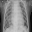

In [ ]:
test



In [ ]:
learn_load.predict(test)

(Category tensor(1), tensor(1), tensor([0.0111, 0.9889]))

In [ ]:
learn.get_preds()

IndexError: ignored

In [ ]:
f1(inp,targ)
learn.get_preds()
learn.data.valid_ds[0][0]